#NinaPro DB5 dataset(電極番号1~8)

ジェスチャ：6種類

準拠するパラメータ：

・batch size = 128

・L2正則化の重み = 0.001

・学習率減衰：1~19 = 0.01, 20~39 = 0.001, 40~50 = 0.0001

・データ比：train:valid:test = 6:1:3

In [1]:
!nvidia-smi

Wed Dec 21 13:04:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   32C    P8    21W / 350W |  24099MiB / 24576MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

dataset
バッチサイズ→128
テストデータ割合→10%

データセットの解凍

In [4]:
#import keras
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten
#from tensorflow.keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler #学習率減衰
from tensorflow.keras import regularizers #L2正則化
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import tensorflow as tf
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPUのメモリ確保を制限

#乱数の設定
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(1)
np.random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

各種設定(データセットの指定など)

In [3]:
train_data_path = 'datasetNina_ExB_1' #データセットのフォルダ名
folder = list(map(str, range(1, 7))) #データセットのクラス名

class_number = len(folder)
print('今回のデータで分類するクラス数は「', str(class_number), '」です。')

今回のデータで分類するクラス数は「 6 」です。


データセットの読み込み・準備

In [1]:
start = time.time()
X_image = []
Y_label = []
Xappend = X_image.append
Yappend = Y_label.append

#クラスごとのループ
for index, name in enumerate(folder): #name:クラスフォルダ名, index:クラスに対応している変数
  read_data = train_data_path + '/' + name

  files = glob.glob(read_data + '/*.npy') #クラスごとのファイルすべてを格納
  #print('--- 読み込んだデータセットは', read_data, 'です。')

  #ファイルごとのループ
  for i, file in enumerate(files):  #i:クラス内の各ファイルに対応している変数
    print('\r', read_data, ': ', i+1, '/', len(files), end='')
    array = np.load(file)

    Xappend(array) #画像データをndarrayとして格納
    Yappend(index) #画像に対応したクラス(画像ラベル)を格納

  print(' --finish: ' + str(int((time.time()-start)/60)) + 'm' + str(int((time.time()-start))%60) + 's')
  
#データセット配列の設定
X_image = np.array(X_image) #データセット全体の画像行列データ＝入力データ
Y_label = np.array(Y_label) #データセット全体の画像ラベル

#画像行列データを正規化
print(X_image.max(), X_image.min())
scale = (X_image.max() - X_image.min())/2
med = (X_image.max() + X_image.min())/2
X_image = (X_image - med)/scale
print(X_image.max(), X_image.min())

Y_label = to_categorical(Y_label, class_number) #Kerasではクラスをベクトルで扱うらしい【おまじない】

#訓練データとテストデータを分割。
x_train, valid_images, y_train, valid_labels = train_test_split(X_image, Y_label, test_size=0.4, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(valid_images, valid_labels, test_size=0.75, random_state=0)

print('train data size: ', len(x_train))
print('valid data size: ', len(x_valid))
print('test data size: ', len(x_test))

NameError: name 'time' is not defined

ch数(1~7)を指定したCNNモデル

In [5]:
BATCH_SIZE = 128
image_size_x = 25 #画像サイズ
image_size_y = 15
channel = 8 
epochnumber = 50
L2weight = 0.001 #Myo: 0.01, Nina: 0.001

#CNNアーキテクチャの設計
model = Sequential()

model.add(BatchNormalization(input_shape=(image_size_x, image_size_y, channel)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))

model.add(GlobalAveragePooling2D())

model.add(Dense(class_number, activation='softmax', kernel_regularizer=regularizers.l2(L2weight)))

#model.summary()

#学習率減衰の設定
def step_decay(epoch):
    x = 0.01
    if epoch >= 20: x = 0.001
    if epoch >= 40: x = 0.0001
    return x
lr_decay = LearningRateScheduler(step_decay)

model.compile(loss='categorical_crossentropy', #損失関数の設定
            optimizer=Adam(learning_rate=0.01), #最適化アルゴリズムの設定
            metrics=['accuracy'] #評価関数の設定
            )

start_time = time.time()

#可視化
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochnumber, 
                    verbose=1, #学習過程を出力するかどうか
                    validation_data=(x_valid, y_valid), 
                    callbacks=[lr_decay] #学習率減衰の設定
                    )

print('Computation time: {0:.3f} sec'.format(time.time() - start_time))

model.save('model/EMGNet_Nina_B6_1.h5') #モデルの保存


Epoch 1/50
224/224 [==============================] - 10s 10ms/step - loss: 1.2255 - accuracy: 0.5074 - val_loss: 1.7939 - val_accuracy: 0.3635 - lr: 0.0100
Epoch 2/50
224/224 [==============================] - 2s 8ms/step - loss: 1.0005 - accuracy: 0.6078 - val_loss: 1.1623 - val_accuracy: 0.5478 - lr: 0.0100
Epoch 3/50
224/224 [==============================] - 2s 8ms/step - loss: 0.9110 - accuracy: 0.6444 - val_loss: 1.0189 - val_accuracy: 0.6263 - lr: 0.0100
Epoch 4/50
224/224 [==============================] - 2s 8ms/step - loss: 0.8509 - accuracy: 0.6686 - val_loss: 0.8589 - val_accuracy: 0.6665 - lr: 0.0100
Epoch 5/50
224/224 [==============================] - 2s 7ms/step - loss: 0.8117 - accuracy: 0.6849 - val_loss: 0.9919 - val_accuracy: 0.6286 - lr: 0.0100
Epoch 6/50
224/224 [==============================] - 2s 8ms/step - loss: 0.7759 - accuracy: 0.6989 - val_loss: 0.8426 - val_accuracy: 0.6788 - lr: 0.0100
Epoch 7/50
224/224 [==============================] - 2s 8ms/step - 

学習曲線の作図(保存したモデルを呼び出して実行)

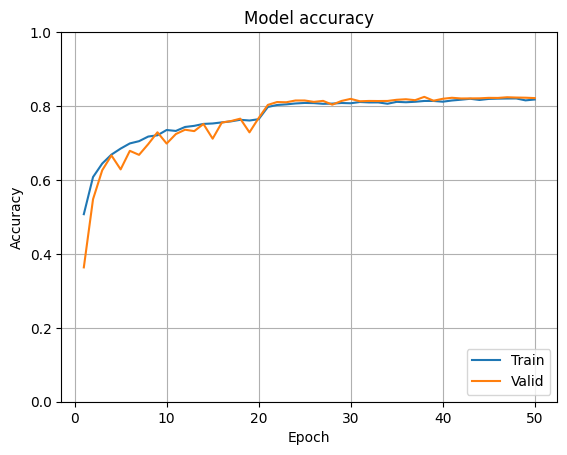

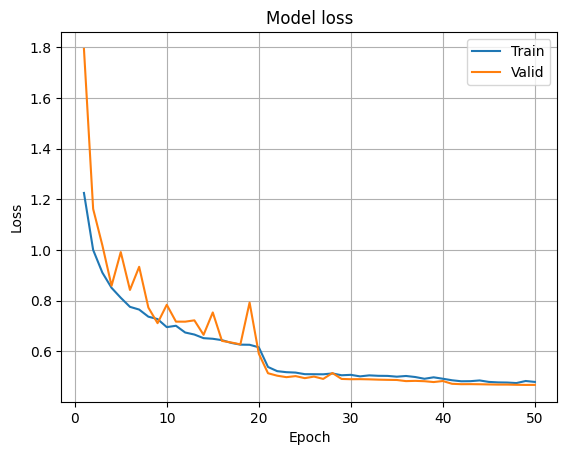

In [6]:
model = load_model('model/EMGNet_Nina_B6_1.h5')

#作図
x = range(1, epochnumber+1)
plt.plot(x, history.history['accuracy'])
plt.plot(x, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
#plt.ylim(0, 8)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

テスト・混同行列の作成(参考：https://newtechnologylifestyle.net/keras_fashion-mnist/)(https://kinpatucom821.hatenablog.com/entry/2018/08/30/215419)

449/449 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
[[2677   54   17   28   14   14]
 [  62 1911  183   93   53   59]
 [  39  217 1957   73   47   43]
 [  52  144   46 1829  369   24]
 [  31   98   68  294 1616   35]
 [  59   87   39   53   30 1922]]


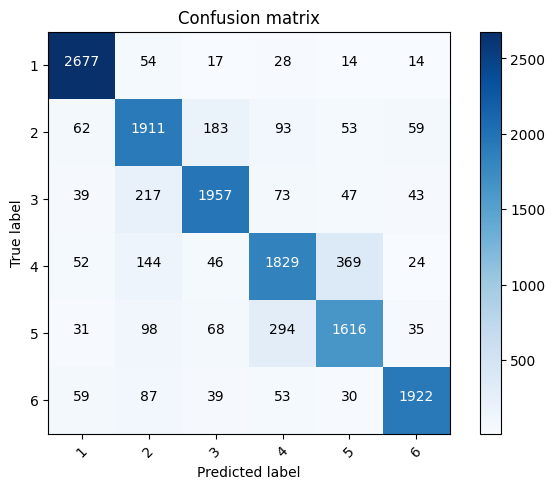

Loss: 0.4535207152366638 （損失関数値 - 0に近いほど正解に近い）
Accuracy: 83.08572173118591 % （精度 - 100% に近いほど正解に近い）


In [7]:
from sklearn.metrics import confusion_matrix
import itertools

model = load_model('model/EMGNet_Nina_B6_1.h5')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

pred_y = model.predict(x_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(1, 7)) 
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）') 
print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）') 

Normalized confusion matrix
[[0.87762557 0.03972603 0.02420091 0.02694064 0.01780822 0.01369863]
 [0.02498941 0.8094028  0.03939009 0.02626006 0.07750953 0.02244812]
 [0.00974026 0.05844156 0.74228896 0.0211039  0.01866883 0.14975649]
 [0.00499287 0.0192582  0.00998573 0.95470756 0.00606277 0.00499287]
 [0.01809764 0.09132997 0.03072391 0.01641414 0.8236532  0.01978114]
 [0.01633987 0.04575163 0.1372549  0.01447246 0.03174603 0.75443511]]


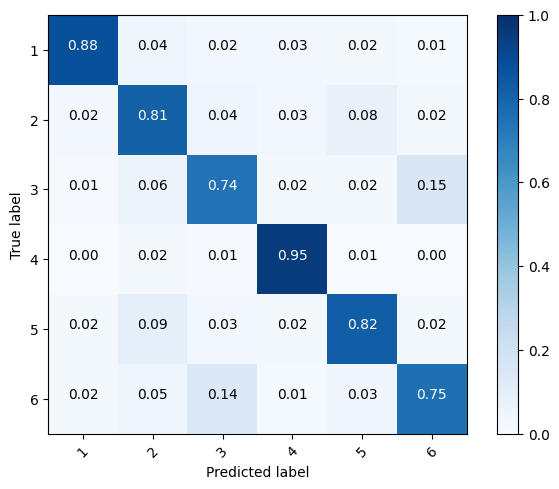

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

#model = load_model('model/EMGNet_Nina_B6_1.h5')

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = [[2677,   54,   17,   28,   14,   14],
                 [  62, 1911,  183,   93,   53,   59],
                 [  39,  217, 1957,   73,   47,   43],
                 [  52,  144,   46, 1829,  369,   24],
                 [  31,   98,   68,  294, 1616,   35],
                 [  59,   87,   39,   53,   30, 1922]]
mtx = np.array(confusion_mtx)
mtx = mtx[[5,1,3,0,2,4]]
mtx = mtx[:,[5,1,3,0,2,4]]

plot_confusion_matrix(mtx, classes = range(1, 7)) 
plt.show()

#score = model.evaluate(x_test, y_test, verbose=0)
#print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）') 
#print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）') 